In [90]:


# Autoreload modules without having to restart the notebook kernel.
# hi bilbo
%load_ext autoreload
%autoreload 2


import sys
import os
import networkx as nx 
import scipy as sp 
import numpy as np
import matplotlib.pyplot as plt

# Introduce the project directory to your system's path to make data/lib folders visible.
sys.path.insert(1, "..")
# Plotting code stolen from Georg's notebook.
# matplotlib inline
font = {'family': 'DejaVu Sans',
        'weight': 'bold',
        'size': 22}
plt.rc('font', **font)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
import lib.files
import lib.graph
import lib.cluster


In [92]:
#shortest path tree

#Given graph, node, find a tree with shortest path to all nodes
def sp_tree(G, n, k=None):
    sp = nx.Graph()
    sp.add_node(n)
    set = []
    set.append(n)
    while set:
        current = set[0]
        set = set[1:]
        nbs = G.neighbors(current)
        for nb in nbs:
            if nb in sp:
                continue
            if k!= None:
                if nx.shortest_path_length(G,nb,n) > k:
                    continue
            set.append(nb)
            sp.add_node(nb)
            sp.add_edge(current, nb)
    return sp
 

In [109]:
G = nx.read_weighted_edgelist("../data/networks/icp55-cc-900-inv.txt", comments="#", nodetype = str)

1. Get all clusters with dist <= 3 from ICP55
2. condense clusters to single node
3. ??????
4. Profit

In [188]:
f = open("../data/clusters/icp55-cc-900-inv.mcl-2.5.csv", "r")

cl = f.read().splitlines()[1:]

node_cl = {} #to get a node's cluster
clusters = {} #to get the list of nodes for a cluster
clustersize = {} # to get the size of the cluster ... kinda redundant
for c in cl:
    node_cl[c.split(',')[2]] = int(c.split(',')[1])
    #if clustersize[c.split(',')[1]] == None:
    #    clustersize[c.split(',')] == 0
    try:
        clusters[int(c.split(',')[1])].append(c.split(',')[2])
        clustersize[int(c.split(',')[1])] += 1      
    except KeyError:
        clusters[int(c.split(',')[1])] = [c.split(',')[2]]
        clustersize[int(c.split(',')[1])] = 1
    

In [189]:
for v in clusters.values():
    print(nx.is_connected(G.subgraph(v)))
    if len(v) == 5:
        print(node_cl[v[0]])

True
True
True
True
True
True
True
True
True
True
True
True
True
True
13
True
True
True
False
True
True
19
True
True
True
22
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
48
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
82
True
True
True
True
86
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
111
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
126
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
141
True
True
True
True
True
True
147
True
True
149
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
166
True
True
False
False
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
187
True
Tru

In [113]:
def equiv_rel(node_a, node_b):
    if node_cl[node_a] == node_cl[node_b] and clustersize[node_cl[node_a]] > 4 and nx.is_connected(G.subgraph(clusters[node_cl[node_a]])):
        return True
    return False

In [119]:
G_cln = nx.algorithms.minors.quotient_graph(G, equiv_rel)

In [145]:
print(G.number_of_edges(), G_cln.number_of_edges())
print(G.number_of_nodes(), G_weighted.number_of_nodes())

61515 5575
4572 1343


In [121]:
mapping = {}
for node in G_cln.nodes:
    if len(node) == 1:
        mapping[node] = [n for n in node][0]
    else:
        mapping[node] = node_cl[[n for n in node][0]]
G_cln = nx.relabel_nodes(G_cln, mapping)

/tmp/ipykernel_36080/2734124441.py:5: RuntimeWarning: divide by zero encountered in power
  plt.plot(x, x**-2)


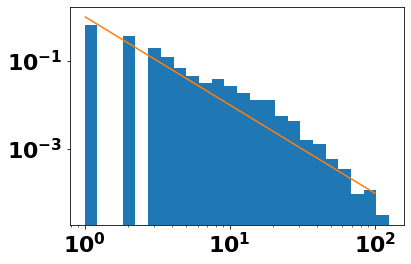

In [179]:
deg = [G_cln.degree[node] for node in G_cln.nodes]
deg.sort()
plt.hist(deg, log = True, density = True, bins =np.logspace(0,2.1,25))
x = np.linspace(0,100,100)
plt.plot(x, x**-2)
plt.xscale('log')

/tmp/ipykernel_36080/678051408.py:6: RuntimeWarning: divide by zero encountered in reciprocal
  plt.plot(x, x**-1)


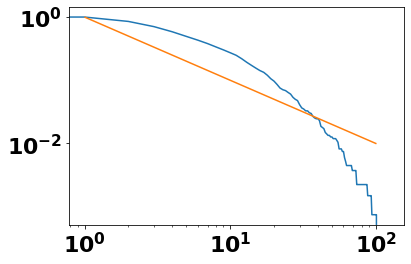

In [125]:
deg = np.array(deg)
nums = [np.count_nonzero(deg == i) for i in range(deg[-1]+1)]
num = [sum(nums[:i]) for i in range(len(nums))]
num = [(num[-1] - num[i])/num[-1] for i in range(len(num))]
plt.plot(num)
plt.plot(x, x**-1)
plt.yscale('log')
plt.xscale('log')

In [126]:
G_weighted = nx.Graph()
#G_weighted.add_edges_from(G.edges, weight)

for edge in G_cln.edges:
    if isinstance(edge[0],int)==False:
        if isinstance(edge[1], int)==False:
            G_weighted.add_edge(edge[0],edge[1], weight = 1)
            continue
    if isinstance(edge[0], int) == True:
        list1 = clusters[edge[0]]
    else:
        list1 = [edge[0]]
    if isinstance(edge[1], int) == True:
        list2 = clusters[edge[1]]
    else:
        list2 = [edge[1]]
    w = 0
    for l1 in list1:
        nb = list(nx.neighbors(G, l1))
        nb.sort()
        common = [v for v in nb if v in list2]
        w += len(common)
    G_weighted.add_edge(edge[0], edge[1], weight = w)

[1.00000000e+00 2.10953215e+00 4.45012590e+00 9.38768368e+00
 1.98036206e+01 4.17763743e+01 8.81286049e+01 1.85910126e+02
 3.92183387e+02 8.27323466e+02 1.74526545e+03 3.68169359e+03
 7.76665100e+03 1.63840000e+04]


Text(0.5, 1.0, 'Degree Density')

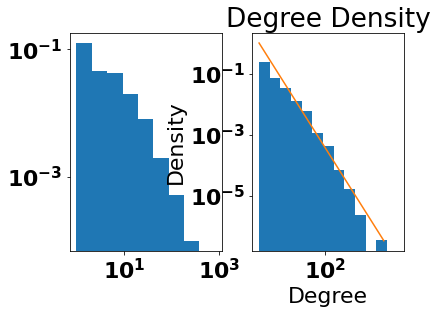

In [175]:
degw = [G_weighted.degree(node, weight='weight') for node in G_weighted.nodes]
bins = 2**(np.linspace(0,14, 14))
print(bins)
degw.sort()
plt.figure()
plt.subplot(121)
plt.hist([G.degree(node) for node in G.nodes], log = True, density = True, bins = bins[:10])
plt.xscale('log')
plt.subplot(122)
plt.hist(degw, log = True, density = True, bins = bins)
plt.xscale('log')
plt.xlabel('Degree')
plt.ylabel('Density')
plt.plot(np.logspace(0, 3.8, 25), np.logspace(0,3.8,25)**-1.7)
plt.title('Degree Density')

In [151]:
for node in G_weighted.nodes:
    if G_weighted.degree(node, weight = 'weight') > 2000:
        print(node, G_weighted.degree(node, weight='weight'))

23 5483
16 5485


In [180]:
subset = []
iscluster = {}
for n in G_cln.nodes:
    if isinstance(n, int):
        subset.append(n)
        iscluster[n] = True
    else:
        iscluster[n] = False
G_clusters = G_weighted.subgraph(subset)
color_map = {False: 'blue', True: 'red'}
size_map = {False: 1, True: 20}

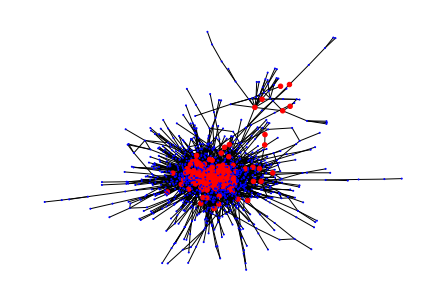

In [181]:
nx.draw(G_weighted, node_color=[color_map[iscluster[node]] for node in G_weighted.nodes], node_size = [size_map[iscluster[node]] for node in G_weighted.nodes])

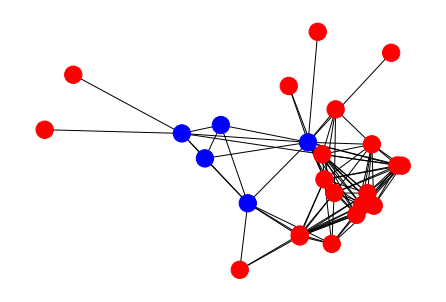

In [203]:
is_in_13 = {}
cluster13_nbs = clusters[19].copy()
for v in clusters[19]:
    cluster13_nbs = list(set(cluster13_nbs + (list(nx.neighbors(G, v)))))
for c in cluster13_nbs:
    if c in clusters[19]:
        is_in_13[c] = True
    else:
        is_in_13[c] = False
cluster13_color = {True: 'blue', False: 'red'}
nx.draw(G.subgraph(cluster13_nbs), node_color = [cluster13_color[is_in_13[node]] for node in cluster13_nbs])